# Seasonal Cycles

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.ticker import FormatStrFormatter, FixedLocator
import matplotlib.dates as mdates
import seaborn as sns
import cartopy
import cartopy.crs as ccrs

In [3]:
from importlib.machinery import SourceFileLoader
plotting = SourceFileLoader("plotting", "../../plotting.py").load_module()
analysis_funcs = SourceFileLoader("analysis_funcs", "../../analysis_funcs.py").load_module()

In [4]:
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
from dask import delayed

USER = os.environ['USER']

/glade/work/gclow/conda-envs/my-npl-ml/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [4]:
cluster = PBSCluster(
    cores=1,
    memory='25GB', 
    processes=1,
    queue='casper',
    local_directory=f'/glade/scratch/{USER}/dask-workers',
    log_directory=f'/glade/scratch/{USER}/dask-workers',
    resource_spec='select=1:ncpus=1:mem=25GB',
    project='P93300070',
    walltime='02:00:00',
    interface='ib0')

client = Client(cluster)
cluster.scale(20)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gclow/Batch/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gclow/Batch/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.51:36939,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gclow/Batch/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


# Functions

In [5]:
def calc_missing_data_cesm(data, weights, weights_nocld, TAREA, mask, calc_missing = True):
    '''
    Calculate % area missing data from cesm POP output using the TAREA cells.
    
    Parameters
    ----------
    data :
    weights : 
    weights_nocld : 
    biome : 
    calc_missing : 
    
    Output
    ------
    df_final : 
    
    '''

    all_data = []
    
    if calc_missing == True: 
        total_area = TAREA.where(mask, drop = True).sum().compute().values
        # Only calculate missing data during the day -- to align with sat data
        cloudy_wgt = weights/weights_nocld 
        TAREA_wgt_clouds_only = TAREA * cloudy_wgt
    
    # TAREA * weights = area of grid cell seen by satellite
    TAREA_wgt = TAREA * weights
        
    for year in np.unique(data.time.dt.year.values).tolist():
        print(year)
        df_list = []
        
        # Subset datasets by region and year
        cloudy_chlor_reg = data.where(mask, drop = True)\
                               .where(data.time.dt.year==year,drop=True)

        TAREA_wgt_reg = TAREA_wgt.where(mask, drop = True)\
                                 .where(TAREA_wgt.time.dt.year==year,drop=True)
        
        if calc_missing == True: 
            TAREA_wgt_clouds_only_reg = TAREA_wgt_clouds_only.where(mask, drop = True)\
                                    .where(TAREA_wgt_clouds_only.time.dt.year==year,drop=True)
        
        # Loop through days in the year
        for date in cloudy_chlor_reg.time.values:
            if calc_missing == True: 
                df_daily = delayed(calc_daily_missing)(date, cloudy_chlor_reg,
                                                       TAREA_wgt_clouds_only_reg,
                                                       TAREA_wgt_reg, total_area)                
                df_list.append(df_daily)

            else: 
                df_daily = delayed(calc_daily_chlor)(date, cloudy_chlor_reg, 
                                                     TAREA_wgt_reg)               
                df_list.append(df_daily)
                
        results = dask.compute(df_list)
        df = pd.concat(results[0]).set_index('date')
        all_data.append(df)
    
    df_final = pd.concat(all_data)
    df_final['mean_chl'] = df_final['mean_chl'].astype(float)
    
    return df_final

def calc_daily_missing(date, cloudy_chlor_reg, TAREA_wgt_clouds_only_reg, TAREA_wgt_reg, total_area):
    
    # Select one day of data
    cloudy_chlor_day = cloudy_chlor_reg.sel(time = date)
    TAREA_wgt_clouds_only_day = TAREA_wgt_clouds_only_reg.sel(time = date).fillna(0)
    TAREA_wgt_reg_day = TAREA_wgt_reg.sel(time = date).fillna(0)

    ## Calculate weighted mean chl in region 
    mean_chl = (cloudy_chlor_day*TAREA.where(mask, drop=True)).sum(dim=['nlat','nlon'])/(TAREA_wgt_reg_day).sum(dim=['nlat','nlon']).compute().values

    ## Calculate missing area
    included_area = TAREA_wgt_clouds_only_day.where(cloudy_chlor_day>0).sum().compute().values
    missing_area = total_area - included_area

    ## Percent nan 
    per_nan = missing_area/total_area

    df_daily = pd.DataFrame(data = {'date': [date], 'percent_missing': [per_nan], 'mean_chl': [mean_chl]})
    return df_daily

def calc_daily_chlor(date, cloudy_chlor_reg, TAREA_wgt_reg):
    
    cloudy_chlor_day = cloudy_chlor_reg.sel(time = date)
    TAREA_wgt_reg_day = TAREA_wgt_reg.sel(time = date).fillna(0)
    
    ## Calculate mean chl in region 
    mean_chl = (cloudy_chlor_day*TAREA.where(mask, drop=True)).sum(dim=['nlat','nlon'])/(TAREA_wgt_reg_day).sum(dim=['nlat','nlon']).compute().values

    df_daily = pd.DataFrame(data = {'date': [date], 'mean_chl': [mean_chl]})
    return df_daily

# Import Data

In [6]:
%%time

base = '/glade/scratch/gclow/archive/b.e22.B1850.f09_g17.cosp_chlor_30yr/ocn/daily/b.e22.B1850.f09_g17.cosp_chlor_30yr.pop.h.ecosys.nday1.'

data = xr.open_mfdataset(base+'*.nc', concat_dim="time", parallel = True, chunks = {'time':365},
                              data_vars='minimal', compat='override', 
                              coords='minimal')
data

CPU times: user 1.13 s, sys: 454 ms, total: 1.58 s
Wall time: 41.6 s


<xarray.Dataset>
Dimensions:                     (time: 10950, nlat: 384, nlon: 320)
Coordinates:
  * time                        (time) object 0020-01-01 00:00:00 ... 0049-12...
    ULONG                       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT                        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Data variables: (12/14)
    totChl                      (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>
    totChl_sat_nocld            (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>
    totChl_sat_nocld_wgt        (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>
    totChl_isccp_wgt            (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>
    totChl_isccp                (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>
    totChl_modis                (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>
    ...                          ...
    totChl_sat_nocld_wgt_swath  (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>
    totChl_modis_swath          (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>
    totChl_modis_wgt_swath      (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>
    cloudfrac_modis             (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>
    cloudfrac_isccp             (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>
    cloudfrac_wgt               (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>

In [7]:
TAREA = xr.open_dataset('/glade/scratch/gclow/archive/b.e22.B1850.f09_g17.cosp_chlor_30yr/ocn/hist/b.e22.B1850.f09_g17.cosp_chlor_30yr.pop.h.nday1.0001-01-01.nc').TAREA
biomes = xr.open_dataset('../data/biomes_regrid_pop.nc')

# Southern Ocean

In [20]:
mask = (biomes.MeanBiomes==16)

southern_oc = data[['totChl_isccp','totChl_isccp_wgt',
                      'totChl_sat_nocld','totChl_sat_nocld_wgt']].where(mask)

In [21]:
# Calculate seasonal cycle for cloud-masked chlorophyll

path = '../data/seasonal_cycle_southern_oc_clouds.csv'
if os.path.exists(path): 
    print('reading file')
    southern_oc_clouds = pd.read_csv('../data/seasonal_cycle_southern_oc_clouds.csv')
else: 
    print('calculating seasonal cycle')
    southern_oc_clouds = calc_missing_data_cesm(southern_oc.totChl_isccp, southern_oc.totChl_isccp_wgt,
                                                    southern_oc.totChl_sat_nocld_wgt, TAREA, mask,
                                                    calc_missing = True)

    southern_oc_clouds.to_csv('../data/seasonal_cycle_southern_oc_clouds.csv')

southern_oc_clouds = southern_oc_clouds.reset_index()
southern_oc_clouds['MM-DD'] = southern_oc_clouds['date'].apply(lambda x: str(x)[5:10])
southern_oc_clouds['month']= pd.to_datetime(southern_oc_clouds['MM-DD']+'-2000')

reading file


In [22]:
# Calculate seasonal cycle for baseline chlorophyll

path = '../data/seasonal_cycle_southern_oc_baseline.csv'
if os.path.exists(path): 
    print('reading file')
    southern_oc_baseline = pd.read_csv('../data/seasonal_cycle_southern_oc_baseline.csv')
else: 
    print('calculating seasonal cycle')
    southern_oc_baseline = calc_missing_data_cesm(southern_oc.totChl_sat_nocld, southern_oc.totChl_sat_nocld_wgt,
                                                southern_oc.totChl_sat_nocld_wgt, TAREA, mask,
                                                calc_missing = False)

    southern_oc_baseline.to_csv('../data/seasonal_cycle_southern_oc_baseline.csv')

southern_oc_baseline = southern_oc_baseline.reset_index()
southern_oc_baseline['MM-DD'] = southern_oc_baseline['date'].apply(lambda x: str(x)[5:10])
southern_oc_baseline['month']= pd.to_datetime(southern_oc_baseline['MM-DD']+'-2000')

reading file


../../plotting.py:176: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(ax1.get_yticks(), size = 16)
../../plotting.py:192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticks(), size = 18)
../../plotting.py:198: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(ax2.get_yticks(), size = 16)


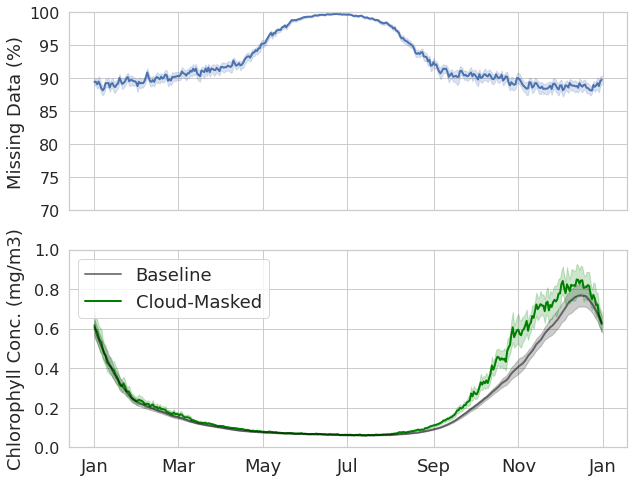

In [27]:
plotting.seasonal_cycle(southern_oc_clouds, southern_oc_baseline, chlor_lim = [0,1])
plt.savefig('../plots/southern_oc_seasonal_cycle.png',bbox_inches = 'tight',pad_inches = 0.3, dpi = 300)

# North Pacific

In [16]:
mask = (biomes.MeanBiomes==2)

north_pacific = data[['totChl_isccp','totChl_isccp_wgt',
                      'totChl_sat_nocld','totChl_sat_nocld_wgt']].where(mask)

In [17]:
# Calculate seasonal cycle for cloud-masked chlorophyll

path = '../data/seasonal_cycle_north_pacific_clouds.csv'
if os.path.exists(path): 
    print('reading file')
    north_pacific_clouds = pd.read_csv('../data/seasonal_cycle_north_pacific_clouds.csv')
else: 
    print('calculating seasonal cycle')
    north_pacific_clouds = calc_missing_data_cesm(north_pacific.totChl_isccp, north_pacific.totChl_isccp_wgt,
                                                    north_pacific.totChl_sat_nocld_wgt, TAREA, mask,
                                                    calc_missing = True)

    north_pacific_clouds.to_csv('../data/seasonal_cycle_north_pacific_clouds.csv')

north_pacific_clouds = north_pacific_clouds.reset_index()
north_pacific_clouds['MM-DD'] = north_pacific_clouds['date'].apply(lambda x: str(x)[5:10])
north_pacific_clouds['month']= pd.to_datetime(north_pacific_clouds['MM-DD']+'-2000')

reading file


In [18]:
# Calculate seasonal cycle for baseline chlorophyll

path = '../data/seasonal_cycle_north_pacific_baseline.csv'
if os.path.exists(path): 
    print('reading file')
    north_pacific_baseline = pd.read_csv('../data/seasonal_cycle_north_pacific_baseline.csv')
else: 
    print('calculating seasonal cycle')
    north_pacific_baseline = calc_missing_data_cesm(north_pacific.totChl_sat_nocld, north_pacific.totChl_sat_nocld_wgt,
                                                north_pacific.totChl_sat_nocld_wgt, TAREA, mask,
                                                calc_missing = False)

    north_pacific_baseline.to_csv('../data/seasonal_cycle_north_pacific_baseline.csv')
    
north_pacific_baseline = north_pacific_baseline.reset_index()
north_pacific_baseline['MM-DD'] = north_pacific_baseline['date'].apply(lambda x: str(x)[5:10])
north_pacific_baseline['month']= pd.to_datetime(north_pacific_baseline['MM-DD']+'-2000')
 

reading file


../../plotting.py:176: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(ax1.get_yticks(), size = 16)
../../plotting.py:192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticks(), size = 18)
../../plotting.py:198: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(ax2.get_yticks(), size = 16)


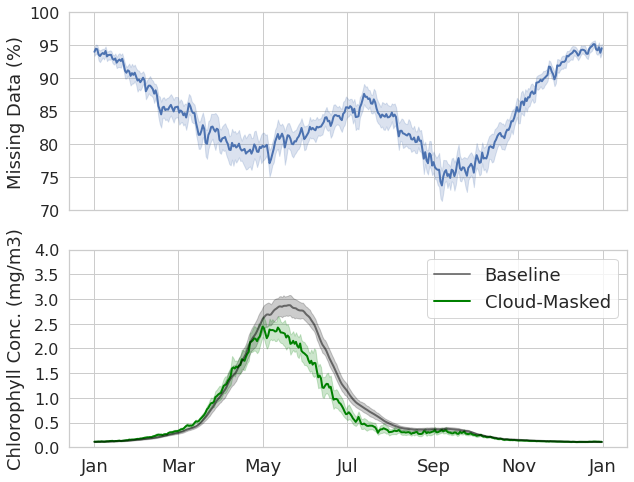

In [24]:
plotting.seasonal_cycle(north_pacific_clouds, north_pacific_baseline)
plt.savefig('../plots/north_pacific_seasonal_cycle.png',bbox_inches = 'tight',pad_inches = 0.3, dpi = 300)


# North Atlantic

In [25]:
region = 'north_atlantic'

mask = (biomes.MeanBiomes==9)

north_atlantic = data[['totChl_isccp','totChl_isccp_wgt',
                      'totChl_sat_nocld','totChl_sat_nocld_wgt']].where(mask)

In [11]:
# Calculate seasonal cycle for cloud-masked chlorophyll

path = '../data/seasonal_cycle_{0}_clouds.csv'.format(region)
if os.path.exists(path): 
    print('reading file')
    north_atlantic_clouds = pd.read_csv('../data/seasonal_cycle_{0}_clouds.csv'.format(region))
else: 
    print('calculating seasonal cycle')
    north_atlantic_clouds = calc_missing_data_cesm(north_atlantic.totChl_isccp, north_atlantic.totChl_isccp_wgt,
                                                    north_atlantic.totChl_sat_nocld_wgt, TAREA, mask,
                                                    calc_missing = True)

    north_atlantic_clouds.to_csv('../data/seasonal_cycle_{0}_clouds.csv'.format(region))

north_atlantic_clouds = north_atlantic_clouds.reset_index()
north_atlantic_clouds['MM-DD'] = north_atlantic_clouds['date'].apply(lambda x: str(x)[5:10])
north_atlantic_clouds['month']= pd.to_datetime(north_atlantic_clouds['MM-DD']+'-2000')

reading file


In [ ]:
# Calculate seasonal cycle for baseline chlorophyll

path = '../data/seasonal_cycle_{0}_baseline.csv'.format(region)
if os.path.exists(path): 
    print('reading file')
    north_atlantic_baseline = pd.read_csv('../data/seasonal_cycle_{0}_baseline.csv'.format(region))
else: 
    print('calculating seasonal cycle')
    north_atlantic_baseline = calc_missing_data_cesm(north_atlantic.totChl_sat_nocld, north_atlantic.totChl_sat_nocld_wgt,
                                                north_atlantic.totChl_sat_nocld_wgt, TAREA, mask,
                                                calc_missing = False)

    north_atlantic_baseline.to_csv('../data/seasonal_cycle_{0}_baseline.csv'.format(region))
    
north_atlantic_baseline = north_atlantic_baseline.reset_index()
north_atlantic_baseline['MM-DD'] = north_atlantic_baseline['date'].apply(lambda x: str(x)[5:10])
north_atlantic_baseline['month']= pd.to_datetime(north_atlantic_baseline['MM-DD']+'-2000')

../../plotting.py:176: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(ax1.get_yticks(), size = 16)
../../plotting.py:192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticks(), size = 18)
../../plotting.py:198: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(ax2.get_yticks(), size = 16)


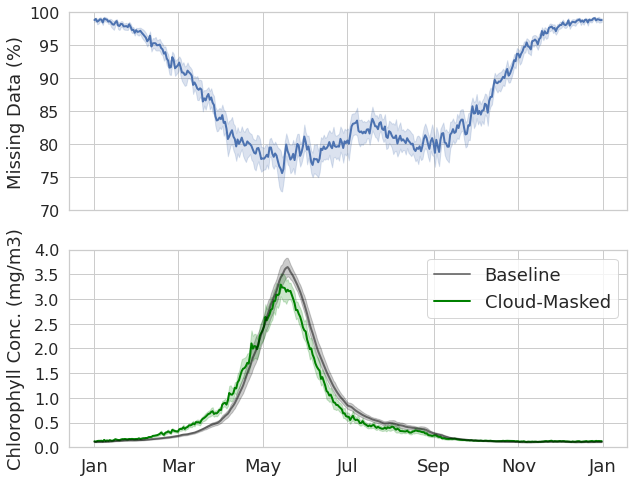

In [26]:
plotting.seasonal_cycle(north_atlantic_clouds, north_atlantic_baseline)
plt.savefig('../plots/{0}_seasonal_cycle.png'.format(region) ,bbox_inches = 'tight',pad_inches = 0.3, dpi = 300)

# Arctic

In [28]:
region = 'arctic'

mask = (biomes.MeanBiomes.isin([1,8]))

arctic = data[['totChl_isccp','totChl_isccp_wgt',
                      'totChl_sat_nocld','totChl_sat_nocld_wgt']].where(mask)

In [ ]:
# Calculate seasonal cycle for cloud-masked chlorophyll

path = '../data/seasonal_cycle_{0}_clouds.csv'.format(region)
if os.path.exists(path): 
    print('reading file')
    arctic_clouds = pd.read_csv('../data/seasonal_cycle_{0}_clouds.csv'.format(region))
else: 
    print('calculating seasonal cycle')
    arctic_clouds = calc_missing_data_cesm(arctic.totChl_isccp, arctic.totChl_isccp_wgt,
                                           arctic.totChl_sat_nocld_wgt, TAREA, mask,
                                           calc_missing = True)

    arctic_clouds.to_csv('../data/seasonal_cycle_{0}_clouds.csv'.format(region))

arctic_clouds = arctic_clouds.reset_index()
arctic_clouds['MM-DD'] = arctic_clouds['date'].apply(lambda x: str(x)[5:10])
arctic_clouds['month']= pd.to_datetime(arctic_clouds['MM-DD']+'-2000')

In [ ]:
# Calculate seasonal cycle for baseline chlorophyll

path = '../data/seasonal_cycle_{0}_baseline.csv'.format(region)
if os.path.exists(path): 
    print('reading file')
    arctic_baseline = pd.read_csv('../data/seasonal_cycle_{0}_baseline.csv'.format(region))
else: 
    print('calculating seasonal cycle')
    arctic_baseline = calc_missing_data_cesm(arctic.totChl_sat_nocld, arctic.totChl_sat_nocld_wgt,
                                             arctic.totChl_sat_nocld_wgt, TAREA, mask,
                                             calc_missing = False)

    arctic_baseline.to_csv('../data/seasonal_cycle_{0}_baseline.csv'.format(region))
    
arctic_baseline = arctic_baseline.reset_index()
arctic_baseline['MM-DD'] = arctic_baseline['date'].apply(lambda x: str(x)[5:10])
arctic_baseline['month']= pd.to_datetime(arctic_baseline['MM-DD']+'-2000')

../../plotting.py:176: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(ax1.get_yticks(), size = 16)
../../plotting.py:192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticks(), size = 18)
../../plotting.py:198: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(ax2.get_yticks(), size = 16)


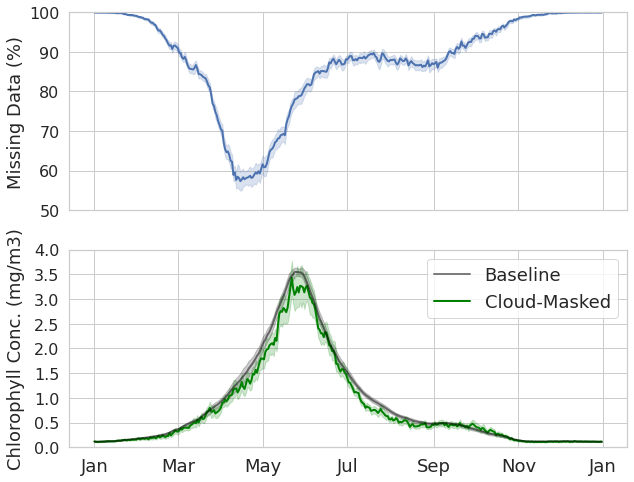

In [33]:
plotting.seasonal_cycle(arctic_clouds, arctic_baseline, cloud_lim = [50,100])
plt.savefig('../plots/{0}_seasonal_cycle.png'.format(region) ,bbox_inches = 'tight',pad_inches = 0.3, dpi = 300)